In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

### read atmospheric CO2 concentration from Mauna Loa

In [80]:
df=pd.read_csv('./co2_mm_mlo.csv',skiprows=56)
df[df<0]=np.nan # replace negative values with NaN
time=df.iloc[:,2] # get the decimal date variable
co2=df['average'].values


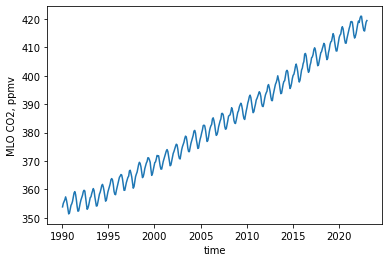

In [81]:
# let's plot data from 1990
ind=(time>=1990)&(~np.isnan(co2))
plt.figure()
plt.plot(time[ind],co2[ind],label='observed')
plt.xlabel('time')
plt.ylabel('MLO CO2, ppmv')

fn='Fig_MLO_CO2'
# plt.savefig(fn+'.pdf',bbox_inches="tight",dpi=300)
# plt.savefig(fn+'.png',bbox_inches="tight",dpi=300)
plt.show()

### Part I: Estimate parameters using MLR, plot the analytic solution

In [87]:
# estimate parameters using MLR
t0=1990
x=time[ind]-t0
y=co2[ind]
N=np.size(x)

# assemble the matrix
A=np.ones((N,3)) # N x 3 matrix
A[:,1]=np.sin(2*np.pi*x) # sin(2*pi*t) term
A[:,2]=x # t-t0 term

# perform MLR using pseudo inverse
xvec=np.linalg.pinv(A)@y

# estimate y using fitted paramters
yest=A@xvec

xvec

array([349.43222865,   2.83697421,   2.04924241])

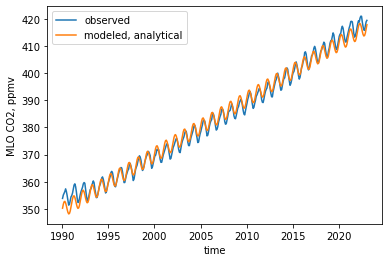

In [83]:
# compare modeled vs. obs. 
plt.figure()
plt.plot(time[ind],y,label='observed')
plt.plot(time[ind],yest,label='modeled, analytical')
plt.xlabel('time')
plt.ylabel('MLO CO2, ppmv')
plt.legend()
fn='Fig_MLO_CO2_MLR_analytical'
plt.savefig(fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig(fn+'.png',bbox_inches="tight",dpi=300)
plt.show()

### Part II: numerical solution

In [84]:
# define the function for dX/dt
def fun_ODE(t,X, B, F, O):
    dX_dt=B*np.cos(2*np.pi*t)+F-O
    return dX_dt

In [85]:
# Numerical solution with Euler forward method
# setup model parameters
dt=0.01 # time step 0.01 year
B=2.837*2*np.pi # respiration and photosynthesis cycles, ppmv/year
F=4.049 # fossil fuel emissions, ppmv/year
O=2 # ocean uptake, ppmv/year

X0=349.432 # initial CO2 concentration at t0
t0=1990 # start time
t1=2023 # end time

# generate time vector
T=np.arange(t0,t1,dt)

# number of time steps
N=np.size(T)

X=0*T # initialize X values with zeros

X[0]=X0 # initial value of X

# forward Euler method
for ii in np.arange(1,N, 1):
    # ii is for the time step n+1
    t=T[ii]-t0 # time of current step
    # X value in the previous time step
    Xn=X[ii-1]    
    dX_dt=fun_ODE(t,Xn, B, F, O)
    X[ii]=Xn+dX_dt*dt

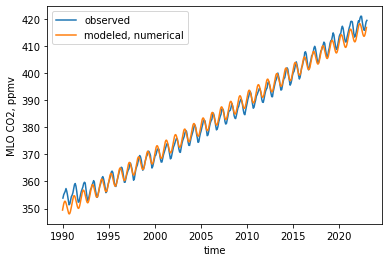

In [86]:
# visualize the results
plt.figure()
plt.plot(time[ind],co2[ind],label='observed')
plt.plot(T,X,label='modeled, numerical')
plt.xlabel('time')
plt.ylabel('MLO CO2, ppmv')
plt.legend()
fn='Fig_MLO_CO2_MLR_numerical'
plt.savefig(fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig(fn+'.png',bbox_inches="tight",dpi=300)
plt.show()

### Part III: Improve the model with actual CO2 emission

In [73]:
# improve the model with time-varied CO2 emissions
# https://ourworldindata.org/co2-emissions#global-co2-emissions

df_emis=pd.read_csv('CO2_Emissions.txt',delimiter='\t',skiprows=1)
data_emis=df_emis.to_numpy()
Year_emis=data_emis[:,0]
# unit: billion tonnes (10^12 kg)
CO2_emis=data_emis[:,1]
CO2_emis

array([22.76, 23.24, 22.58, 22.81, 22.97, 23.46, 24.16, 24.3 , 24.21,
       24.73, 25.45, 25.67, 26.28, 27.65, 28.64, 29.61, 30.59, 31.51,
       32.09, 31.56, 33.36, 34.49, 35.01, 35.32, 35.58, 35.56, 35.52,
       36.1 , 36.83, 37.08, 35.26, 37.12, 37.45])

In [74]:
# convert emission from tonne/year to ppmv per year
m_air=5.148e18 # total mass of atmosphere, kg
CO2_emis_ppm=CO2_emis*1e12/m_air*(29/44)*1e6 # convert the unit: ppm/year
CO2_emis_ppm

array([2.9139295 , 2.9753832 , 2.89088437, 2.92033093, 2.9408155 ,
       3.00354948, 3.09316946, 3.11109345, 3.09957088, 3.16614572,
       3.25832627, 3.28649255, 3.36458996, 3.53998905, 3.6667373 ,
       3.79092498, 3.91639295, 4.0341792 , 4.10843576, 4.04058063,
       4.271032  , 4.41570425, 4.48227908, 4.52196793, 4.55525535,
       4.55269478, 4.54757364, 4.62183019, 4.71529102, 4.74729816,
       4.51428622, 4.7524193 , 4.79466872])

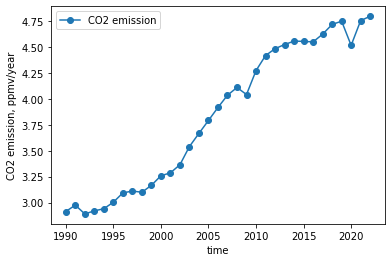

In [75]:
plt.figure()
plt.plot(Year_emis,CO2_emis_ppm,'o-',label='CO2 emission')
plt.xlabel('time')
plt.ylabel('CO2 emission, ppmv/year')
plt.legend()
fn='Fig_CO2_emis'
plt.savefig(fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig(fn+'.png',bbox_inches="tight",dpi=300)
plt.show()

In [76]:
# construct an interpolation for CO2 emission
f_interp = interpolate.interp1d(Year_emis, CO2_emis_ppm)

In [78]:
# Numerical solution 
# setup model parameters
dt=0.01 # time step 0.01 year
# B=3*2*np.pi # respiration and photosynthesis cycles, ppmv/year
B=21
# we will dynamically update F and O values in the loop
# F=4 # fossil fuel emissions, ppmv/year
# O=2 # ocean uptake, ppmv/year

co2_sel=co2[ind].values

X0=co2_sel[0] # initial CO2 concentration at t0
t0=1990 # start time
t1=2022 # end time

# generate time vector
T=np.arange(t0,t1,dt)

# number of time steps
N=np.size(T)

X=0*T # initialize X values with zeros

X[0]=X0 # initial value of X

# Euler forward method
for ii in np.arange(1,N, 1):
    # ii is for the time step n+1
    t=T[ii]-t0 # time of current step
    F=f_interp(T[ii]) # dynamically update emission of CO2
    O=0.475*F
#     O=0.475*F # fraction of CO2 emission absorbed by the ocean
    # X value in the previous time step
    Xn=X[ii-1]    
    dX_dt=fun_ODE(t,Xn, B, F, O)
    X[ii]=Xn+dX_dt*dt

In [65]:
X0

353.86

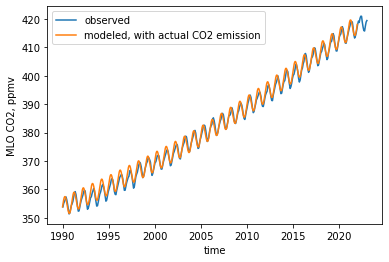

In [79]:
# visualize the results
plt.figure()
plt.plot(time[ind],co2[ind],label='observed')
plt.plot(T,X,label='modeled, with actual CO2 emission')
plt.xlabel('time')
plt.ylabel('MLO CO2, ppmv')
plt.legend()
fn='Fig_MLO_CO2_MLR_numerical_wCO2emis'
plt.savefig(fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig(fn+'.png',bbox_inches="tight",dpi=300)
plt.show()